In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft, rfftfreq, fft, ifft, fftfreq
from numpy.fft import irfft 
from tqdm import tqdm
from time import time
import seaborn as sns

plt.rcParams["font.size"] = 18
plt.rcParams['figure.figsize'] = (15,5)
df = pd.read_csv("SRU_data.txt", skiprows=1, header=None,sep="  ", dtype="float64",
                 names=["u1","u2","u3","u4", "u5", "y1", "y2"] )
X = df.iloc[:,:5].values
y1 = df.iloc[:,5].values
y2 = df.iloc[:,6].values

# Train/Test = 2/8
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.8,shuffle=False)
# X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.8, shuffle=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


# SRUプラントデータに提案手法を適用

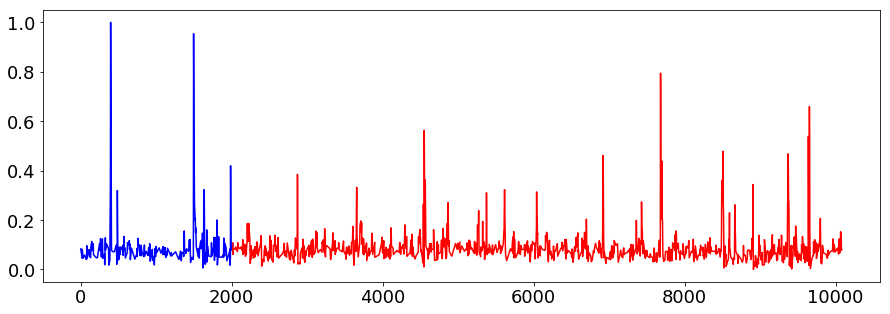

In [19]:
plt.plot(range(len(y_train)),y_train,'b')
plt.plot(range(len(y_train),len(y_train)+len(y_test)),y_test,'r')

In [14]:
y_train_batch = y_train
n = y_train_batch.size # 切り出し後のtrainデータのサイズ

#detrend
t = range(n)
p = np.polyfit(t, y_train_batch, 1) #1次でいいのかな?(非線形もありうる)
y_train_detrended = y_train_batch - p[0]*t

#FFT
y_train_freqdom = fft(y_train_detrended)
f = fftfreq(n) #周波数軸

#restore signal
t = np.arange(0, n_all) #時間領域のx軸
restored_sig = np.zeros(t.size) #ここに復元シグナルを重ね合わせていく

for i in range(f.size//2): #過学習を防ぐため最大の復元率は50%に設定
    indexes = set([i,-i])
    for index in indexes:
        ampli = np.absolute(y_train_freqdom[index])/n
        phase = np.angle(y_train_freqdom[index])
        restored_sig += ampli*np.cos(2*np.pi*f[index]*t + phase)
    extrapolation = restored_sig + p[0]*t

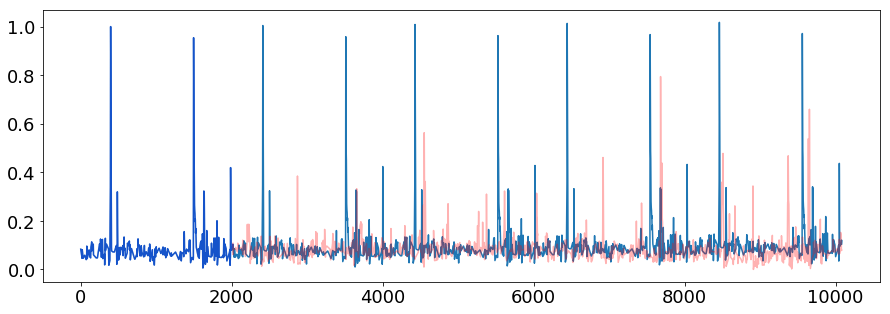

In [18]:
plt.plot(extrapolation)
plt.plot(range(len(y_train)),y_train,'b',alpha=0.3)
plt.plot(range(len(y_train),len(y_train)+len(y_test)),y_test,'r',alpha=0.3)

In [10]:
# train領域を1/10ずつ広げてみる
metrics = []
n_all = y_train.size+y_test.size
for i in tqdm(range(y_train.size//100, y_train.size, y_train.size//100)):
    
    #cutout train data
    y_train_batch = y_train[:i]
    n = y_train_batch.size # 切り出し後のtrainデータのサイズ

    #detrend
    t = range(n)
    p = np.polyfit(t, y_train_batch, 1) #1次でいいのかな?(非線形もありうる)
    y_train_detrended = y_train_batch - p[0]*t

    #FFT
    y_train_freqdom = fft(y_train_detrended)
    f = fftfreq(n) #周波数軸

    #restore signal
    t = np.arange(0, n_all) #時間領域のx軸
    restored_sig = np.zeros(t.size) #ここに復元シグナルを重ね合わせていく
    r2_train = []
    r2_test = []
    for i in range(f.size//2): #過学習を防ぐため最大の復元率は50%に設定
        indexes = set([i,-i])
        for index in indexes:
            ampli = np.absolute(y_train_freqdom[index])/n
            phase = np.angle(y_train_freqdom[index])
            restored_sig += ampli*np.cos(2*np.pi*f[index]*t + phase)
        extrapolation = restored_sig + p[0]*t
        r2_train.append(r2(y_train, extrapolation[:n_train]))
        r2_test.append(r2(y_test, extrapolation[n_train:]))
    metrics.append([r2_train,r2_test])



100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


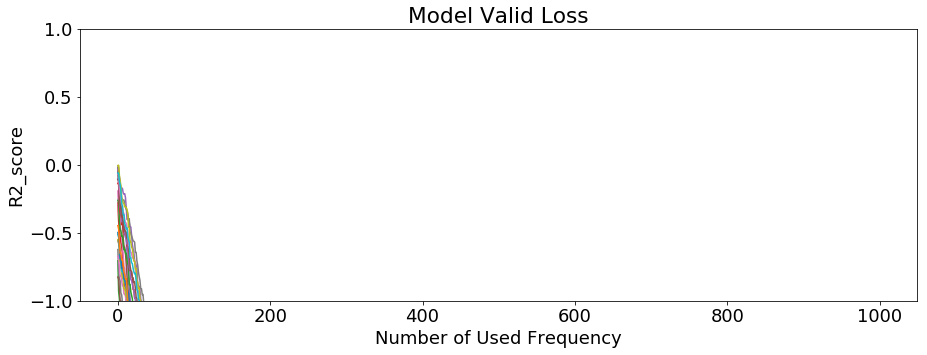

In [13]:
# metrics[データセットの番号][train(0)かvali(1)か]
plt.figure()
plt.ylim([-1,1])
plt.title('Model Valid Loss')
plt.ylabel('R2_score')
plt.xlabel('Number of Used Frequency')
for i in range(len(metrics)):
    
    plt.plot(metrics[i][1])
plt.show()

# Toy ProblemとしてAirPassengersのデータセットに提案手法を適用

In [31]:
df = pd.read_csv('AirPassengers.csv')

In [32]:
y = df.iloc[:,1].values
y1_train = y[:int(len(y)*0.8)]
y1_valid = y[int(len(y)*0.8):]
x = range(len(y))

In [33]:
n_predict = y1_valid.size #validデータのサイズ
n_train = y1_train.size #trainデータのサイズ
n_all = n_predict + n_train #全データのサイズ

In [36]:
# train領域を1/10ずつ広げてみる
metrics = []

for i in tqdm(range(y1_train.size//10, y1_train.size, y1_train.size//10)):
    
    #cutout train data
    y1_train_batch = y1_train[:i]
    n = y1_train_batch.size # 切り出し後のtrainデータのサイズ

    #detrend
    t = range(n)
    p = np.polyfit(t, y1_train_batch, 1) #1次でいいのかな?(非線形もありうる)
    y1_train_detrended = y1_train_batch - p[0]*t

    #FFT
    y1_train_freqdom = fft(y1_train_detrended)
    f = fftfreq(n) #周波数軸

    #restore signal
    t = np.arange(0, n_all) #時間領域のx軸
    restored_sig = np.zeros(t.size) #ここに復元シグナルを重ね合わせていく
    r2_train = []
    r2_valid = []
    for i in range(f.size): #過学習を防ぐため最大の復元率は50%に設定
        indexes = set([i,-i])
        for index in indexes:
            ampli = np.absolute(y1_train_freqdom[index])/n
            phase = np.angle(y1_train_freqdom[index])
            restored_sig += ampli*np.cos(2*np.pi*f[index]*t + phase)
        extrapolation = restored_sig + p[0]*t
        r2_train.append(r2(y1_train, extrapolation[:n_train]))
        r2_valid.append(r2(y1_valid, extrapolation[n_train:]))
    metrics.append([r2_train,r2_valid])
    plt.figure()
    plt.plot()


100%|██████████| 10/10 [00:00<00:00, 38.82it/s]


In [60]:
metrics[9][1]

[0.06654611422059453,
 0.07138146200594297,
 0.055344990661889026,
 0.04556258275716096,
 0.05611313412241836,
 0.05664222628352222,
 0.0633334246558116,
 0.01607862753097722,
 -0.08259849930033725,
 0.3081679309337967,
 0.24425642306142836,
 0.2124298382115255,
 0.21735292136330975,
 0.21564229588637385,
 0.2056402067218488,
 0.2116476092255376,
 0.21378461060638332,
 0.17847748344991343,
 0.19532045125957742,
 0.15068786775251397,
 0.12186945604989041,
 0.11892184478033818,
 0.11968442498863885,
 0.1172842974872671,
 0.12032834023522121,
 0.11946805963866924,
 0.115445021134014,
 0.12223021647401111,
 0.1168531017908292,
 0.11515204378993382,
 0.11315293935086024,
 0.11320420814120713,
 0.11276398958841294,
 0.112272155721996,
 0.1105881609765409,
 0.10914354827909012,
 0.10641853711329197,
 0.1022350970731849,
 0.09937669639508384,
 0.09964322915941304,
 0.09971763929558763,
 0.09954044513040716,
 0.1003252980455287,
 0.09988806012697449,
 0.09992415794914933,
 0.09717561361769111,


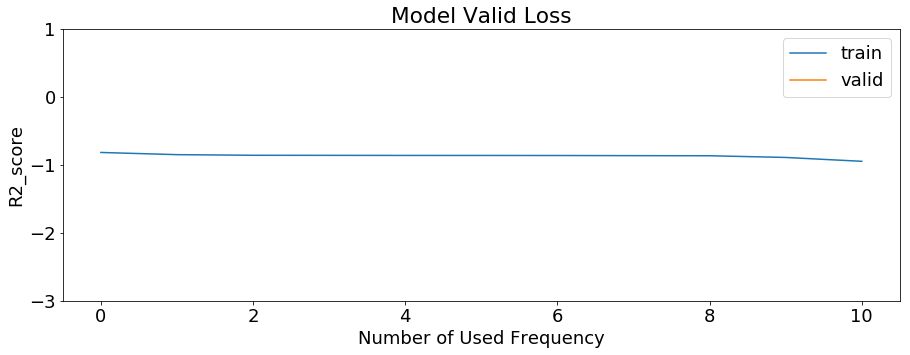

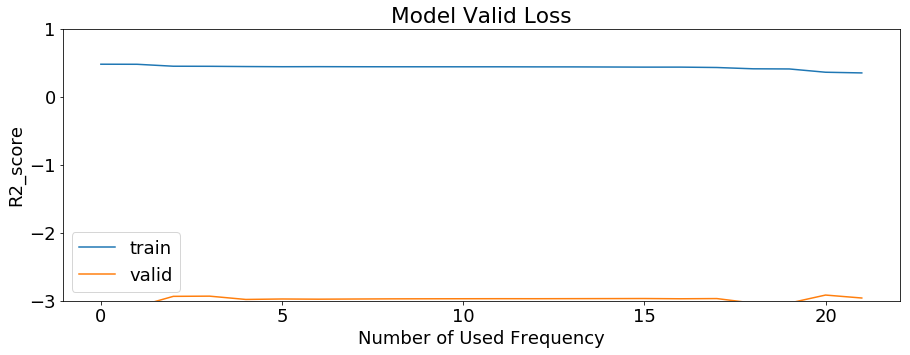

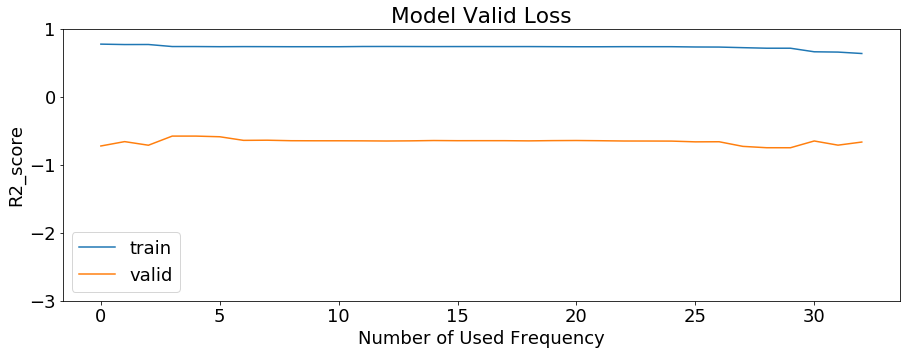

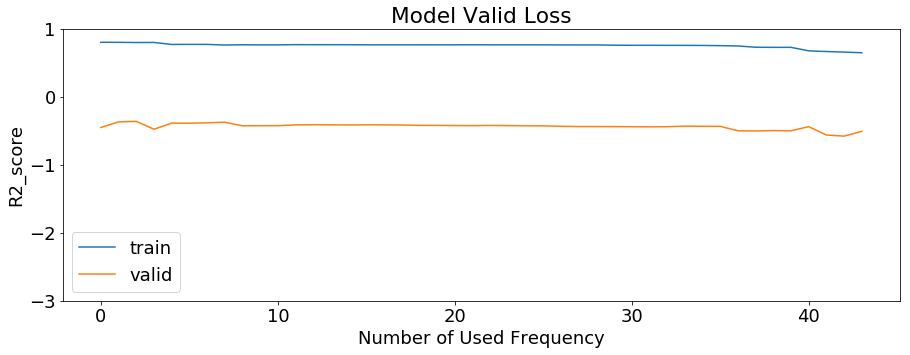

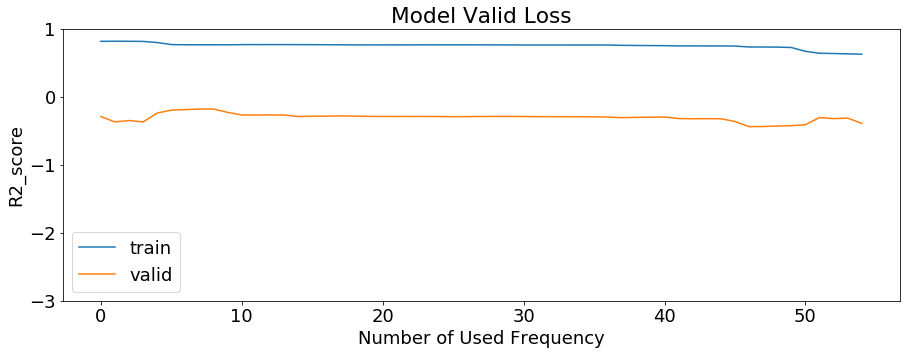

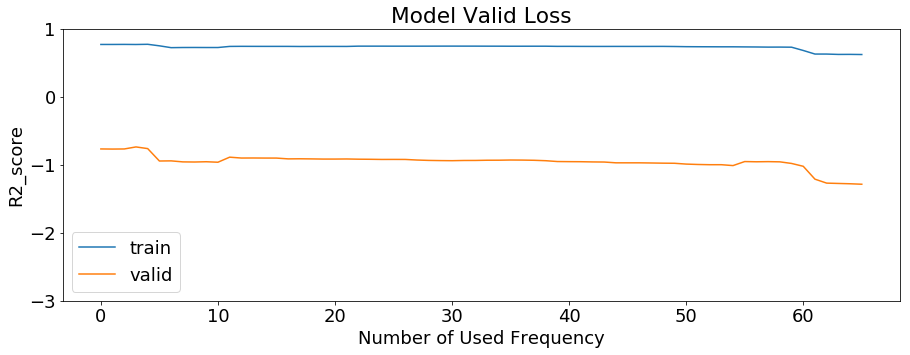

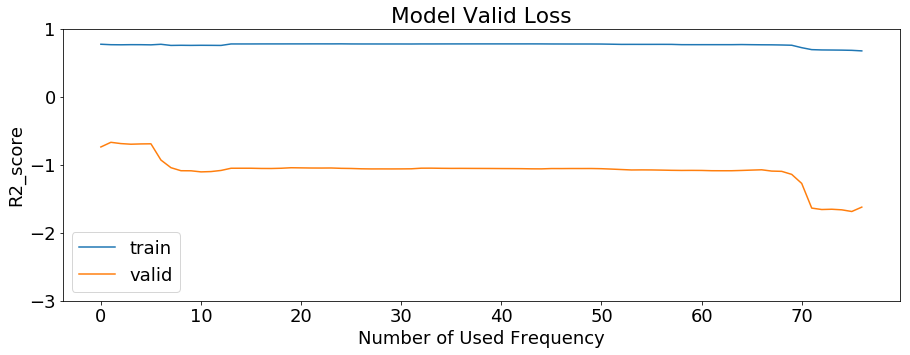

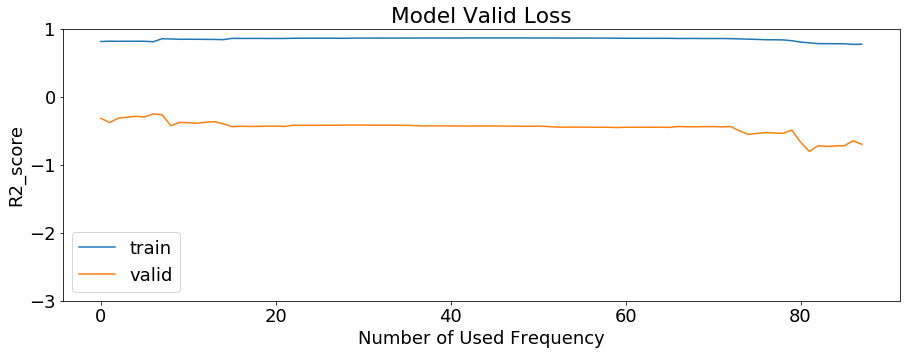

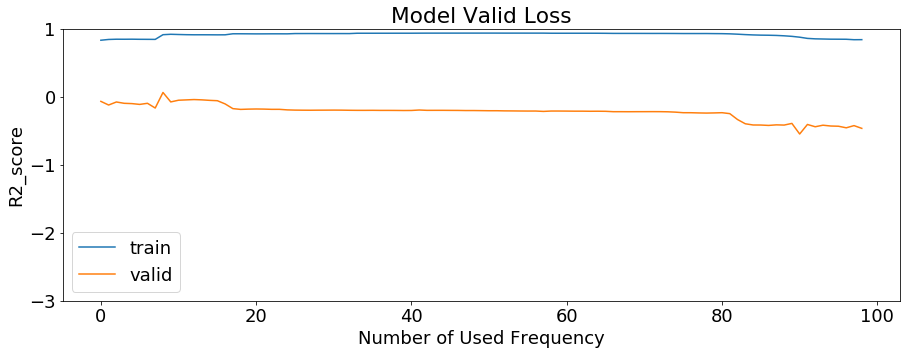

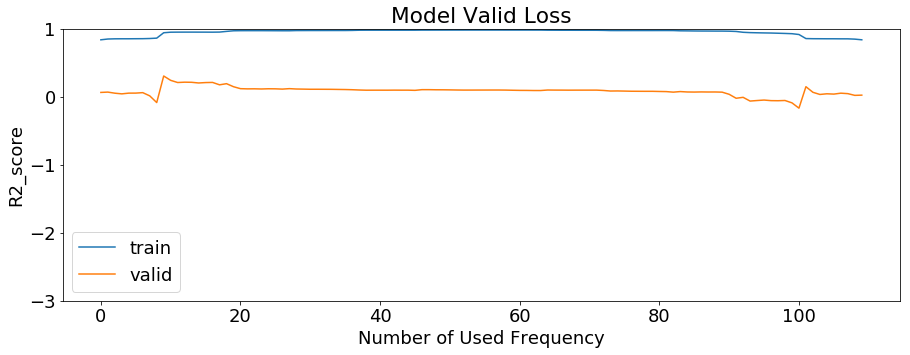

In [47]:
# metrics[データセットの番号][train(0)かvali(1)か]
for i in range(len(metrics)):
    plt.figure()
    plt.title('Model Valid Loss')
    plt.ylabel('R2_score')
    plt.xlabel('Number of Used Frequency')
    plt.plot(metrics[i][0],label='train')
    plt.plot(metrics[i][1],label='valid')
    plt.ylim([-3,1])
    plt.legend()
    plt.show()

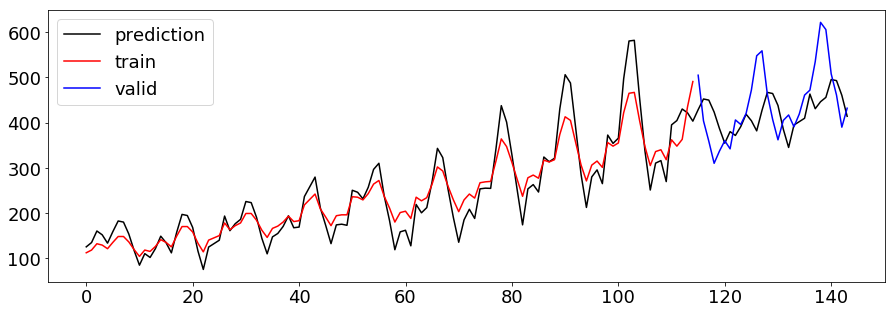

In [59]:
plt.plot(extrapolation, 'k-', label='prediction')
plt.plot(range(len(y1_train)), y1_train, 'r-', label='train')
plt.plot(range(len(y1_train),len(y1_train)+len(y1_valid)), y1_valid, 'b-', label='valid')
plt.legend(loc='best')

In [ ]:
diff_y1_train = y1_train - extrapolation[:y1_train.size]
diff_y1_train=diff_y1_train.reshape(-1,1) # tensorflowの都合上の次元変換
diff_y1_valid = y1_valid - extrapolation[y1_train.size:y1_train.size+y1_valid.size]
diff_y1_valid=diff_y1_valid.reshape(-1,1)

In [ ]:
import tensorflow as tf
class linear:
    
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        
        with self.g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op = tf.global_variables_initializer()
            
    def build(self):
        
        self.X = tf.placeholder(dtype=tf.float32, shape=(None, self.x_dim), name='x_input')
        self.y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y_input')
        
        w = tf.Variable(tf.zeros(shape=(self.x_dim,1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        
        self.z_net = tf.squeeze(tf.matmul(self.X,w)+b ,name='sqr_errors') #出力
        
        sqr_errors = tf.square(self.y - self.z_net, name = "sqr_errors") #誤差
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost') #平均誤差
    
        
        #オプティマイザを作成
        optimizer = tf.train.GradientDescentOptimizer(
                    learning_rate = self.learning_rate,
                    name="GradientDescent")
        self.optimizer = optimizer.minimize(self.mean_cost)
        self.sess = tf.Session(graph=self.g)

    def fit(self, X_train, y_train, X_valid, y_valid, num_epochs=100, earlystop=5):
        
        training_costs = []
        valid_costs = []
        early_count = 0
        base = np.inf
        
        self.sess.run(self.init_op) 
        
        for i in tqdm(range(num_epochs)):
            _, train_cost = self.sess.run([self.optimizer, self.mean_cost],
                              feed_dict={self.X:X_train, self.y:y_train})
            training_costs.append(train_cost)
            valid_cost = self.sess.run(self.mean_cost, feed_dict={self.X:X_valid, self.y:y_valid})
            valid_costs.append(valid_cost)
            
            '''early stopping'''
            if base > valid_cost: 
                base = valid_cost
                count = 0
            else:
                count += 1
            if count > earlystop:
                break            
            
        return training_costs, valid_costs
    
    def predict(self, X_valid):
        y_pred = self.sess.run(self.z_net, feed_dict={self.X:X_valid})
        return y_pred
    
        

100%|██████████| 100/100 [00:01<00:00, 94.16it/s]

Execution Time : 1.073s


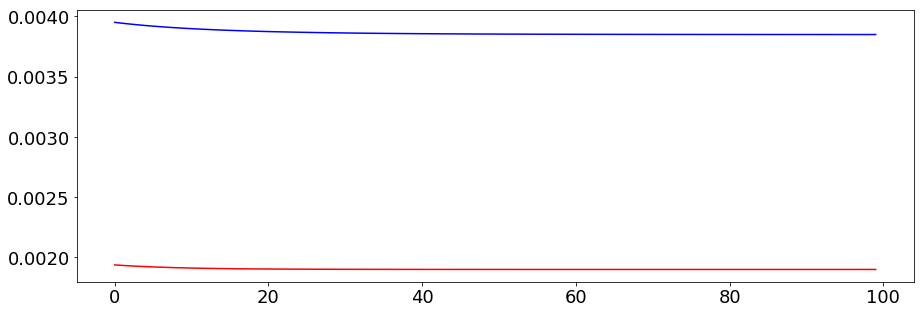

In [22]:
lrmodel = linear(x_dim=X_train.shape[1], learning_rate=0.01)
t0=time()
train_log, valid_log = lrmodel.fit(X_train, diff_y1_train, X_valid, diff_y1_valid)
print("Execution Time : {:.3f}s".format(time()-t0))
pl.plot(train_log, 'r', valid_log, 'b')

0.0038489068712032224


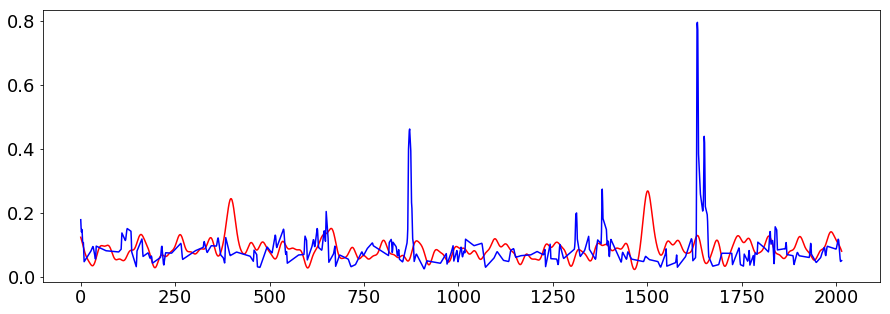

In [23]:
y_predict = lrmodel.predict(X_valid)
pred_y1_valid = extrapolation[y1_train.size:y1_train.size+y1_valid.size] + y_predict
pl.plot(pred_y1_valid, 'r', y1_valid, 'b')
print("{}".format(mse(pred_y1_valid, y1_valid)))

### ARで予測

In [ ]:
import tensorflow as tf
class linear:
    
    def __init__(self, x_dim, time_step, learning_rate=0.01, random_seed=None):
        
        self.x_dim = x_dim
        self.time_step = time_step
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        
        with self.g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op = tf.global_variables_initializer()
            
    def build(self):
        
        self.X = tf.placeholder(dtype=tf.float32, shape=(None, self.time_step, self.x_dim), name='x_input')
        self.y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y_input')
        
        w = tf.Variable(tf.zeros(shape=(self.x_dim,1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        
        self.z_net = tf.squeeze(tf.matmul(self.X,w)+b ,name='sqr_errors') #出力
        
        sqr_errors = tf.square(self.y - self.z_net, name = "sqr_errors") #誤差
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost') #平均誤差
    
        
        #オプティマイザを作成
        optimizer = tf.train.GradientDescentOptimizer(
                    learning_rate = self.learning_rate,
                    name="GradientDescent")
        self.optimizer = optimizer.minimize(self.mean_cost)
        self.sess = tf.Session(graph=self.g)

    def fit(self, X_train, y_train, X_valid, y_valid, num_epochs=100, earlystop=5):
        
        training_costs = []
        valid_costs = []
        early_count = 0
        base = np.inf
        
        self.sess.run(self.init_op) 
        
        for i in tqdm(range(num_epochs)):
            _, train_cost = self.sess.run([self.optimizer, self.mean_cost],
                              feed_dict={self.X:X_train, self.y:y_train})
            training_costs.append(train_cost)
            valid_cost = self.sess.run(self.mean_cost, feed_dict={self.X:X_valid, self.y:y_valid})
            valid_costs.append(valid_cost)
            
            '''early stopping'''
            if base > valid_cost: 
                base = valid_cost
                count = 0
            else:
                count += 1
            if count > earlystop:
                break            
            
        return training_costs, valid_costs
    
    def predict(self, X_valid):
        y_pred = self.sess.run(self.z_net, feed_dict={self.X:X_valid})
        return y_pred
    
        

In [25]:
print(X_train_time.shape)
print(y1_train_time.shape)

(6037, 10, 5)
(6037, 1)


In [ ]:
def generator(X, y, time_steps=10):
    
    n_batches = X.shape[0] - time_steps - 1
    X_time = np.zeros((n_batches, time_steps, X.shape[1]))
    y_time = np.zeros((n_batches, 1))    
    for i in range(n_batches):
        X_time[i] = X[i:(i+time_steps),:]
        y_time[i] = y[i+time_steps]
                
    return X_time, y_time
X_train_time, y1_train_time = generator(X_train, y1_train)
X_valid_time, y1_valid_time = generator(X_valid, y1_valid)
X_test_time, y1_test_time = generator(X_test, y1_test)

In [ ]:
lrmodel = linear(x_dim=X_train.shape[1], learning_rate=0.01)
train_log, valid_log = lrmodel.fit(X_train, diff_y1_train, X_valid, diff_y1_valid)
pl.plot(train_log, 'r', valid_log, 'b')

In [61]:
import os

In [62]:
os.getcwd()

'/home/user4/notebook/research'

In [64]:
import sys

In [66]:
sys.path

['',
 '/opt/conda/lib/python36.zip',
 '/opt/conda/lib/python3.6',
 '/opt/conda/lib/python3.6/lib-dynload',
 '/home/user4/.local/lib/python3.6/site-packages',
 '/opt/conda/lib/python3.6/site-packages',
 '/home/user0/notebook/jupyterlab-git',
 '/opt/conda/lib/python3.6/site-packages/IPython/extensions',
 '/home/user4/.ipython']

In [ ]:
import pathlib
import sys
p = pathlib.Path('..')
sys.path.append(str(p.resolve()))

In [81]:
p1 = pathlib.Path('.')
p2 = pathlib.Path('..')
p3 = pathlib.Path('../../')

In [82]:
print(p1.resolve())
print(p2.resolve())
print(p3.resolve())

/home/user4/notebook/research
/home/user4/notebook
/home/user4


In [86]:
sys.path.append(str(p3.resolve()))
print(sys.path)

['', '/opt/conda/lib/python36.zip', '/opt/conda/lib/python3.6', '/opt/conda/lib/python3.6/lib-dynload', '/home/user4/.local/lib/python3.6/site-packages', '/opt/conda/lib/python3.6/site-packages', '/home/user0/notebook/jupyterlab-git', '/opt/conda/lib/python3.6/site-packages/IPython/extensions', '/home/user4/.ipython', PosixPath('/home/user4'), PosixPath('/home/user4'), '/home/user4']
